In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
from sklearn.ensemble import RandomForestClassifier

from imblearn.over_sampling import SMOTE

In [149]:
# Read data from csv files into DataFrame "merged_all"
merged_all = pd.read_csv(r'C:\Users\HT\OneDrive - ueh.edu.vn\Máy tính\Data Mining\final project\Data\merged_all.csv')

# Display the first 5 rows of DataFrame "merged_all"
merged_all.head()

,Loại hợp đồng,Số người phụ thuộc,Địa chỉ thường trú,Ngành,Nghề nghiệp,Địa chỉ công ty (tỉnh thành),ID hợp đồng,Cân nặng,Trình độ học vấn,Doanh thu,...,Tiền phạt quá hạn (VND),Số ngày quá hạn hợp đồng,Khách hàng quá hạn (ngày),Ngày trả,Khoản trả,Trễ hạn (tháng),Lịch sử quá hạn (hợp đồng),Thanh toán (tháng),Lịch sử quá hạn (khách hàng),Nhóm quá hạn
0,4.0,1.0,35.0,18.0,NaN,NaN,765326.0,87.0,NaN,12264000.0,...,0.0,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,B0
1,4.0,1.0,35.0,18.0,NaN,NaN,765326.0,87.0,NaN,12264000.0,...,0.0,0.0,0.0,2022-07-08 00:00:00.000,588.784058,0.0,0.0,1.0,0.0,B0
2,4.0,1.0,35.0,18.0,NaN,NaN,765326.0,87.0,NaN,12264000.0,...,0.0,0.0,0.0,2022-08-08 00:00:00.000,585.946528,0.0,0.0,2.0,0.0,B0
3,4.0,1.0,35.0,18.0,NaN,NaN,765326.0,87.0,NaN,12264000.0,...,0.0,0.0,0.0,2022-09-12 00:00:00.000,583.095189,1.0,2.0,3.0,2.0,B0
4,4.0,1.0,35.0,18.0,NaN,NaN,765326.0,87.0,NaN,12264000.0,...,0.0,0.0,0.0,2022-10-03 00:00:00.000,584.522597,1.0,2.0,4.0,2.0,B0


In [160]:
#Nhóm để ý trong 2 tháng đầu kể từ ngày giải ngân thì số lượng hợp đồng trả không đúng hạn chiếm rất nhỏ
buf = merged_all[merged_all['Thanh toán (tháng)'] >= 3].copy()

buf['Thanh toán (tháng tiếp theo)'] = buf['Thanh toán (tháng)'] + 1

supbuf = buf[['ID hợp đồng','Thanh toán (tháng)','Nhóm quá hạn','Số ngày quá hạn hợp đồng']].copy()

In [161]:
# Merge DataFrame "buf" and itself into DataFrame "buf1" containing data at the current month on book and the next month on book
buf = buf.merge(
    right=supbuf,
    right_on=['ID hợp đồng', 'Thanh toán (tháng)'],
    left_on=['ID hợp đồng', 'Thanh toán (tháng tiếp theo)'],
    how='left'   # hoặc 'inner' tùy mục đích
)

# Take out records in DataFrame "buf1" that have the current month on book equal to 12, the current bucket is B0 and
# the next month's bucket it higher than B0, and assign collected data back to DataFrame "buf1"
buf = buf[
    (buf['Thanh toán (tháng)_x'] < 12) &
    (buf['Nhóm quá hạn_x'] == 'B0') &
    (buf['Số ngày quá hạn hợp đồng_y'] <= 30) #
].copy()

# Create a new column "ROLL" in DataFrame "buf1" to indicates if the contracts roll to a higher bucket in the next month
buf['ROLL'] = np.where(buf['Số ngày quá hạn hợp đồng_y'] == 0, 0, 1)

# Check the number of distinct values in column "ROLL" in DataFrame "buf1"
buf['ROLL'].value_counts()

0    308117
1     20485
Name: ROLL, dtype: int64

In [162]:
buf.drop(columns=['Thanh toán (tháng)_y','Nhóm quá hạn_y','Số ngày quá hạn hợp đồng_y'], inplace=True)

buf.columns = ['_'.join(col[:-1]) if 'x' in col else '_'.join(col) for col in buf.columns.str.split('_').values]

In [188]:
training_data = buf[['ID hợp đồng','Nghề nghiệp', 'Trễ hạn (tháng)', 'Lịch sử quá hạn (khách hàng)', 'Loại hình cư trú','Lãi suất (tháng)','ROLL']].copy()

In [189]:
# Drop all missing values in every column and assign collected data back to DataFrame "buf"
training_data.dropna(inplace=True)

In [194]:
# Isolate dependent variables and independent variable and assign them respectively to "X" and "Y"
X = training_data.drop(columns=['ROLL','ID hợp đồng'])
y = training_data.loc[:, ['ROLL']]

# Split data for training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0, stratify=y)
y_train.value_counts()

ROLL
0       141887
1         9376
dtype: int64

In [195]:
# Initialize object SMOTE with "sampling_strategy" set to 0.75 to ensure that the model will not overfit or underfit the data
smote = SMOTE(sampling_strategy=0.75, random_state=0)
# Fit and resample the training datasets
smote_X_train, smote_y_train = smote.fit_resample(X_train, y_train)

# Display the percentage of distinct values in training target dataset
smote_y_train.value_counts(normalize=True) * 100


ROLL
0       57.142915
1       42.857085
dtype: float64

In [196]:
# Assign strategies to evaluate the performance of cross-validated model on the test set to the list "scoring"
scoring = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']

In [197]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

lr = LogisticRegression(max_iter=1000)

lr_params = {
    'C': [0.01, 0.1, 1, 10],
    'penalty': ['l2'],
    'solver': ['lbfgs'],
    'class_weight': [None, 'balanced']
}

gs_lr = GridSearchCV(
    estimator=lr,
    param_grid=lr_params,
    scoring=scoring,
    refit='recall',
    cv=4,
    n_jobs=-1
)
gs_lr.fit(smote_X_train, smote_y_train)

c:\Users\HT\AppData\Local\Programs\Orange\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GridSearchCV(cv=4, estimator=LogisticRegression(max_iter=1000), n_jobs=-1,
             param_grid={'C': [0.01, 0.1, 1, 10],
                         'class_weight': [None, 'balanced'], 'penalty': ['l2'],
                         'solver': ['lbfgs']},
             refit='recall',
             scoring=['accuracy', 'precision', 'recall', 'f1', 'roc_auc'])

In [198]:
models = {
    'Logistic Regression': gs_lr
}

best_parameters = {}
model_with_best_params = {}
score ={}

for name, gs in models.items():
    est = gs.estimator
    fitted_est = gs.best_estimator_
    y_pred = fitted_est.predict(X_test)

    print(f'---Kết quả mô hình {name}---')
    
    print(gs.best_score_)
    print(gs.best_params_)

    best_parameters[name] = gs.best_params_
    model_with_best_params[name] = est

    print('---Feature importance---')

    if hasattr(fitted_est, 'feature_importances_'):
        importances = pd.DataFrame(
            fitted_est.feature_importances_,
            index=X.columns,
            columns=['gini_importance']
        ).sort_values(by='gini_importance', ascending=False)
        print(importances.head(10))

    elif hasattr(fitted_est, 'coef_'):
        gini_vars = []

        for col in X.columns:
            auc = roc_auc_score(y, X[col])
            gini_vars.append({
                'feature': col,
                'gini_importance': 2 * auc - 1
            })
        importances = pd.DataFrame(gini_vars).sort_values('gini_importance', ascending=False)
        print(importances.head(10))

    else:
        print('Model này không có feature importance trực tiếp')

    score[name] = {
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred),
        'recall': recall_score(y_test, y_pred),
        'f1': f1_score(y_test, y_pred)
    }
    print('---Áp dụng cho tập TEST---')
    print(f'Accuracy: {score[name]["accuracy"]}')
    print(f'Precision: {score[name]["precision"]}')
    print(f'Recall: {score[name]["recall"]}')
    print(f'F1: {score[name]["f1"]}')

    # AUC cần predict_proba
    if hasattr(fitted_est, 'predict_proba'):
        y_prob = fitted_est.predict_proba(X_test)[:, 1]
        print(f'AUC: {roc_auc_score(y_test, y_prob)}')
    else:
        print('AUC: không tính được (no predict_proba)')

    print('\n')


---Kết quả mô hình Logistic Regression---
0.5766668225558798
{'C': 1, 'class_weight': 'balanced', 'penalty': 'l2', 'solver': 'lbfgs'}
---Feature importance---
                        feature  gini_importance
2  Lịch sử quá hạn (khách hàng)         0.481222
1               Trễ hạn (tháng)         0.429538
4              Lãi suất (tháng)         0.075841
3              Loại hình cư trú         0.067247
0                   Nghề nghiệp         0.055898
---Áp dụng cho tập TEST---
Accuracy: 0.7931219134884274
Precision: 0.16657539247900693
Recall: 0.584
F1: 0.25921454442156094
AUC: 0.7555546177266576




In [199]:
proba_to_roll = gs_lr.best_estimator_.predict_proba(X)[:, 1]

# Display the probabilities
np.sort(proba_to_roll)

array([0.19616568, 0.19616568, 0.19616568, ..., 1.        , 1.        ,
       1.        ])

In [200]:
# Calculate the gini score
gini_score = 2 * roc_auc_score(y_test, gs_lr.best_estimator_.predict_proba(X_test)[:, 1]) - 1
gini_score

0.5111092354533151

In [201]:
# Calculate the ks score
fpr, tpr, _ = roc_curve(y_test, y_pred)
ks_score = max(tpr - fpr)
ks_score

0.3909392760487145

In [202]:
# Calculate the psi score
def calculate_psi(expected, actual, bins=10):
    expected_percents = np.histogram(expected, bins=bins, range=(0, 1), density=True)[0]
    actual_percents = np.histogram(actual, bins=bins, range=(0, 1), density=True)[0]
    expected_percents += 1e-10
    actual_percents += 1e-10
    psi = np.sum((actual_percents - expected_percents) * np.log(actual_percents / expected_percents))
    return psi

psi_score = calculate_psi(gs_lr.best_estimator_.predict_proba(X_train)[:, 1], gs_lr.best_estimator_.predict_proba(X_test)[:, 1])
psi_score

0.0012545479633316195

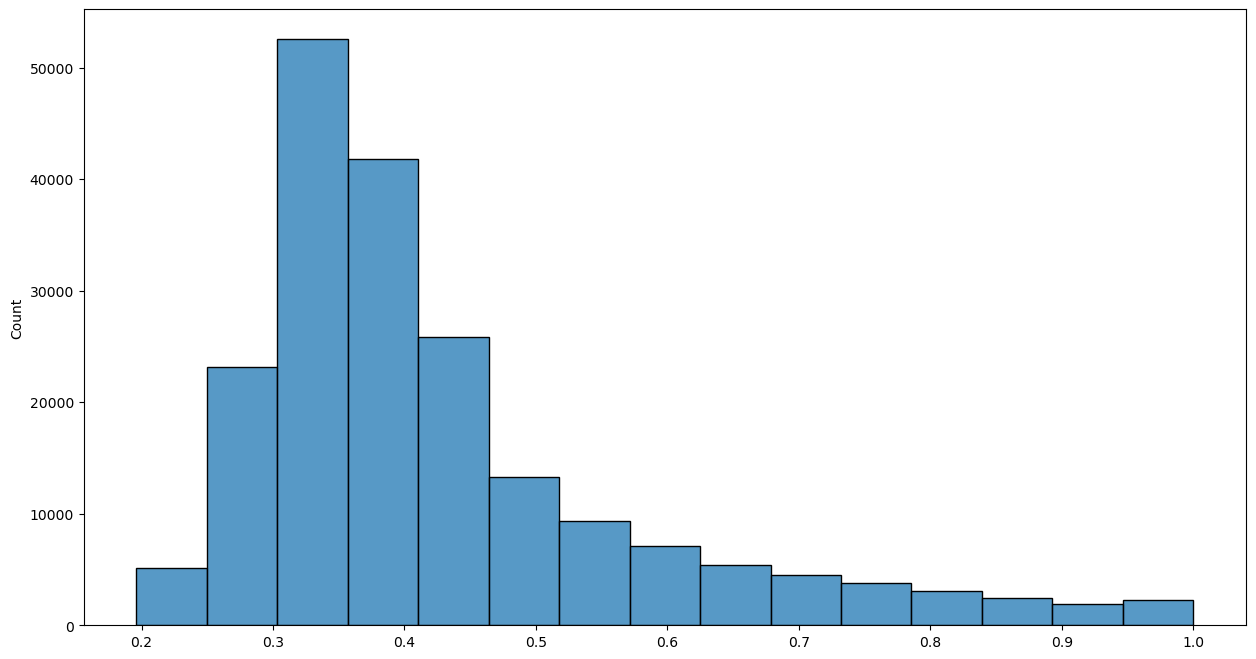

In [203]:
plt.figure(figsize=(15, 8))
sns.histplot(data=proba_to_roll, bins=15)
plt.show()

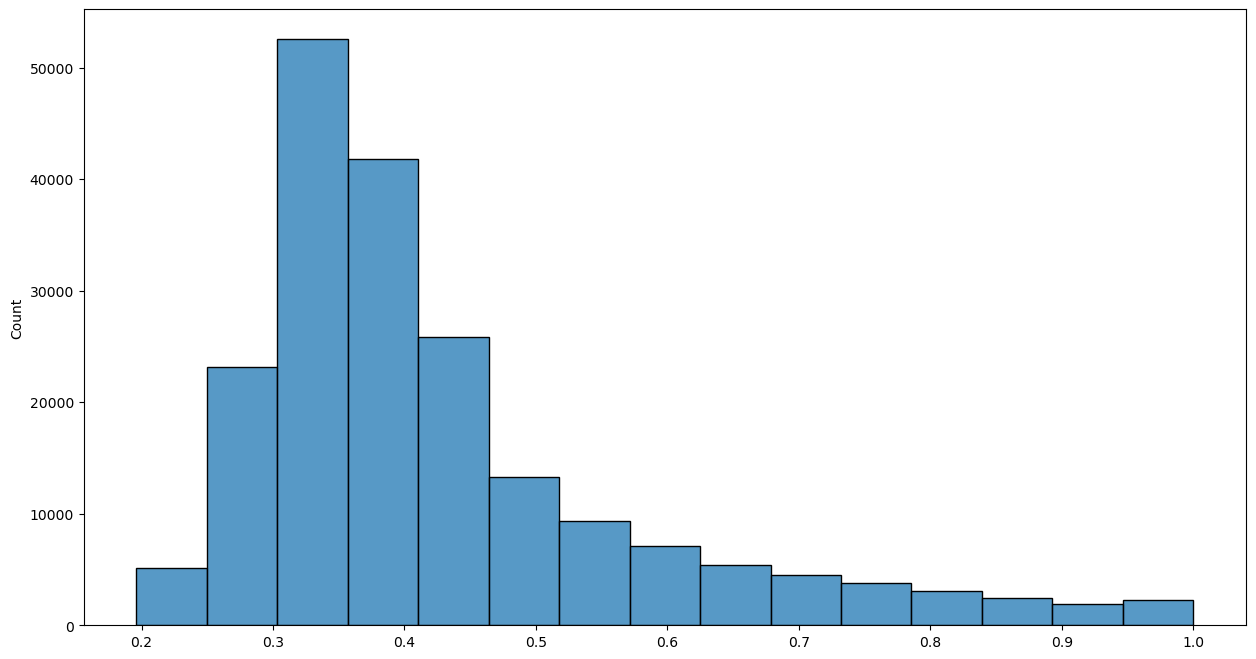

In [204]:
plt.figure(figsize=(15, 8))
sns.histplot(data=proba_to_roll[proba_to_roll > 0], bins=15)
plt.show()

In [205]:
# Assign roll score band for each record
training_data['PROBA_TO_ROLL'] = proba_to_roll

bins = [-np.inf, 0, 0.1, 0.2, 0.35, 0.5, 0.65, 0.8, 0.9, np.inf]
labels = ['AAA', 'AA', 'A', 'BBB', 'BB', 'B', 'CCC', 'CC', 'C']

training_data['ROLL_SCORE_BANDS'] = pd.cut(
    training_data['PROBA_TO_ROLL'],
    bins=bins,
    labels=labels,
    right=True,
    include_lowest=True
)

training_data['ROLL_SCORE_BANDS'].value_counts()

BB     84375
BBB    73725
B      22828
CCC    11860
CC      4996
C       3882
A         18
AAA        0
AA         0
Name: ROLL_SCORE_BANDS, dtype: int64

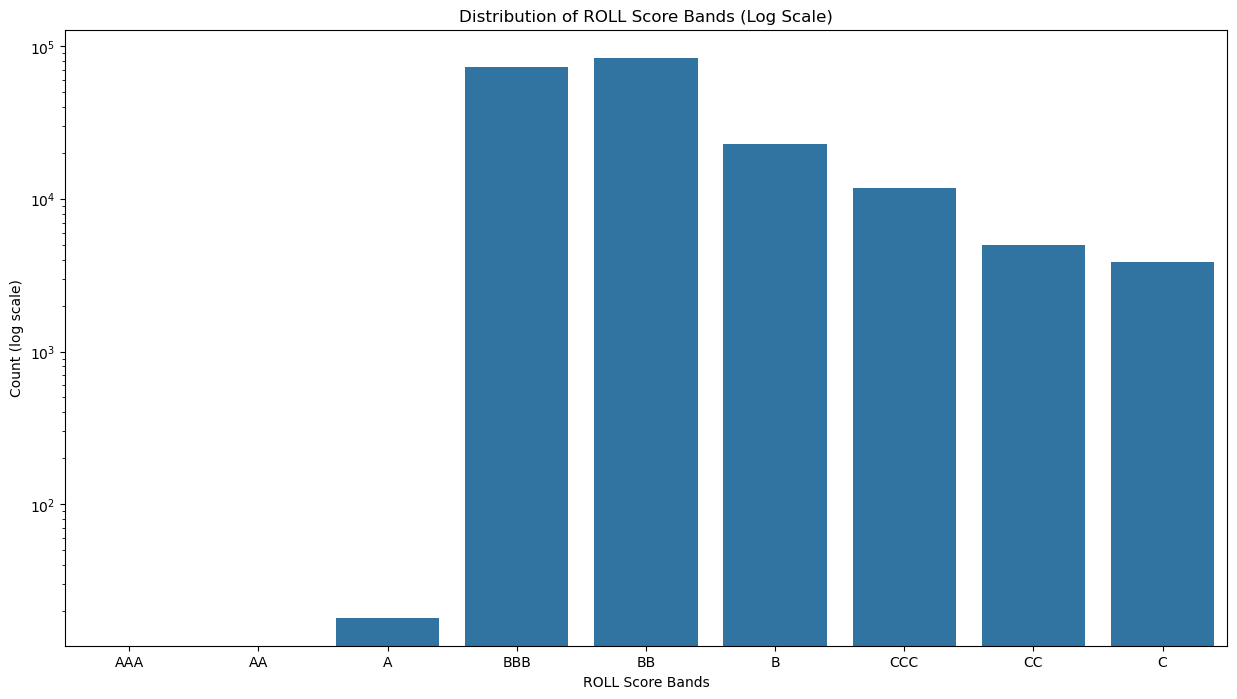

In [209]:
# Plot the distribution of roll score band
plt.figure(figsize=(15, 8))
ax = sns.barplot(data=training_data.groupby(by='ROLL_SCORE_BANDS')['ID hợp đồng'].count(), order=labels)
ax.set_yscale('log')   
ax.set_ylabel('Count (log scale)')
ax.set_xlabel('ROLL Score Bands')
ax.set_title('Distribution of ROLL Score Bands (Log Scale)')

plt.show()